# EDA dan Preprocessing: Berita FAKE vs REAL

Notebook ini melakukan **Analisis Data Eksplorasi (EDA)** dan **Preprocessing** untuk dataset teks berita FAKE dan REAL.

Tujuan utama adalah memahami karakteristik teks, menyiapkan data agar siap untuk tahap modeling, serta menerapkan beberapa metode **Feature Extraction** seperti **Bag of Words (BoW)** dan **TF-IDF**, sesuai materi *Feature Extraction and Selection*.

Link Dataset: https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news/data

## 1. Data Acquisition

### 1.1 Import Library
Bagian ini memuat pustaka Python yang digunakan untuk manipulasi data, visualisasi, dan analisis teks.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import string

%matplotlib inline
print("Library siap digunakan!")

Library siap digunakan!


### 1.2 Memuat Dataset
Dataset berisi dua kolom utama: `text` dan `label`.
Kolom `label` menunjukkan kategori berita apakah FAKE atau REAL.

In [10]:
df = pd.read_csv('data/text_real_or_fake_news.csv')
print("Ukuran dataset:", df.shape)
df.head()

Ukuran dataset: (6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## 2. Data Profiling / EDA
Langkah awal dilakukan untuk memahami struktur, distribusi label, dan karakteristik teks.

In [11]:
df.info()
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB

Jumlah nilai yang hilang per kolom:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


C:\Users\Hibino\AppData\Local\Temp\ipykernel_9564\820972159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


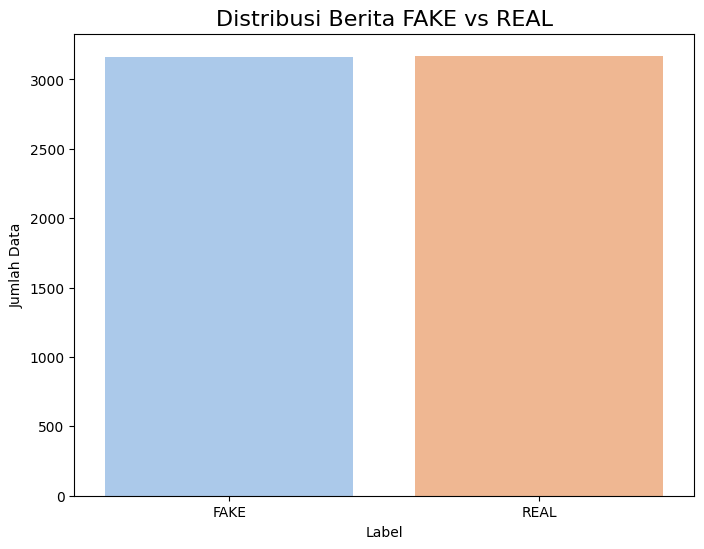

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=df, palette='pastel')
plt.title('Distribusi Berita FAKE vs REAL', fontsize=16)
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()
df['label'].value_counts()

### 2.1 Analisis Panjang dan Struktur Teks
Fitur dasar seperti jumlah kata, karakter, dan panjang rata-rata kata membantu memahami kompleksitas teks tiap label.

In [13]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df[['label','word_count','char_count','avg_word_length']].head()

c:\Users\Hibino\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Hibino\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,label,word_count,char_count,avg_word_length
0,FAKE,1296,7549,4.776235
1,FAKE,446,2654,4.917040
2,REAL,431,2559,4.883991
3,FAKE,404,2673,5.554455
4,REAL,317,1860,4.776025


C:\Users\Hibino\AppData\Local\Temp\ipykernel_9564\1311263738.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='avg_word_length', palette='Set2')


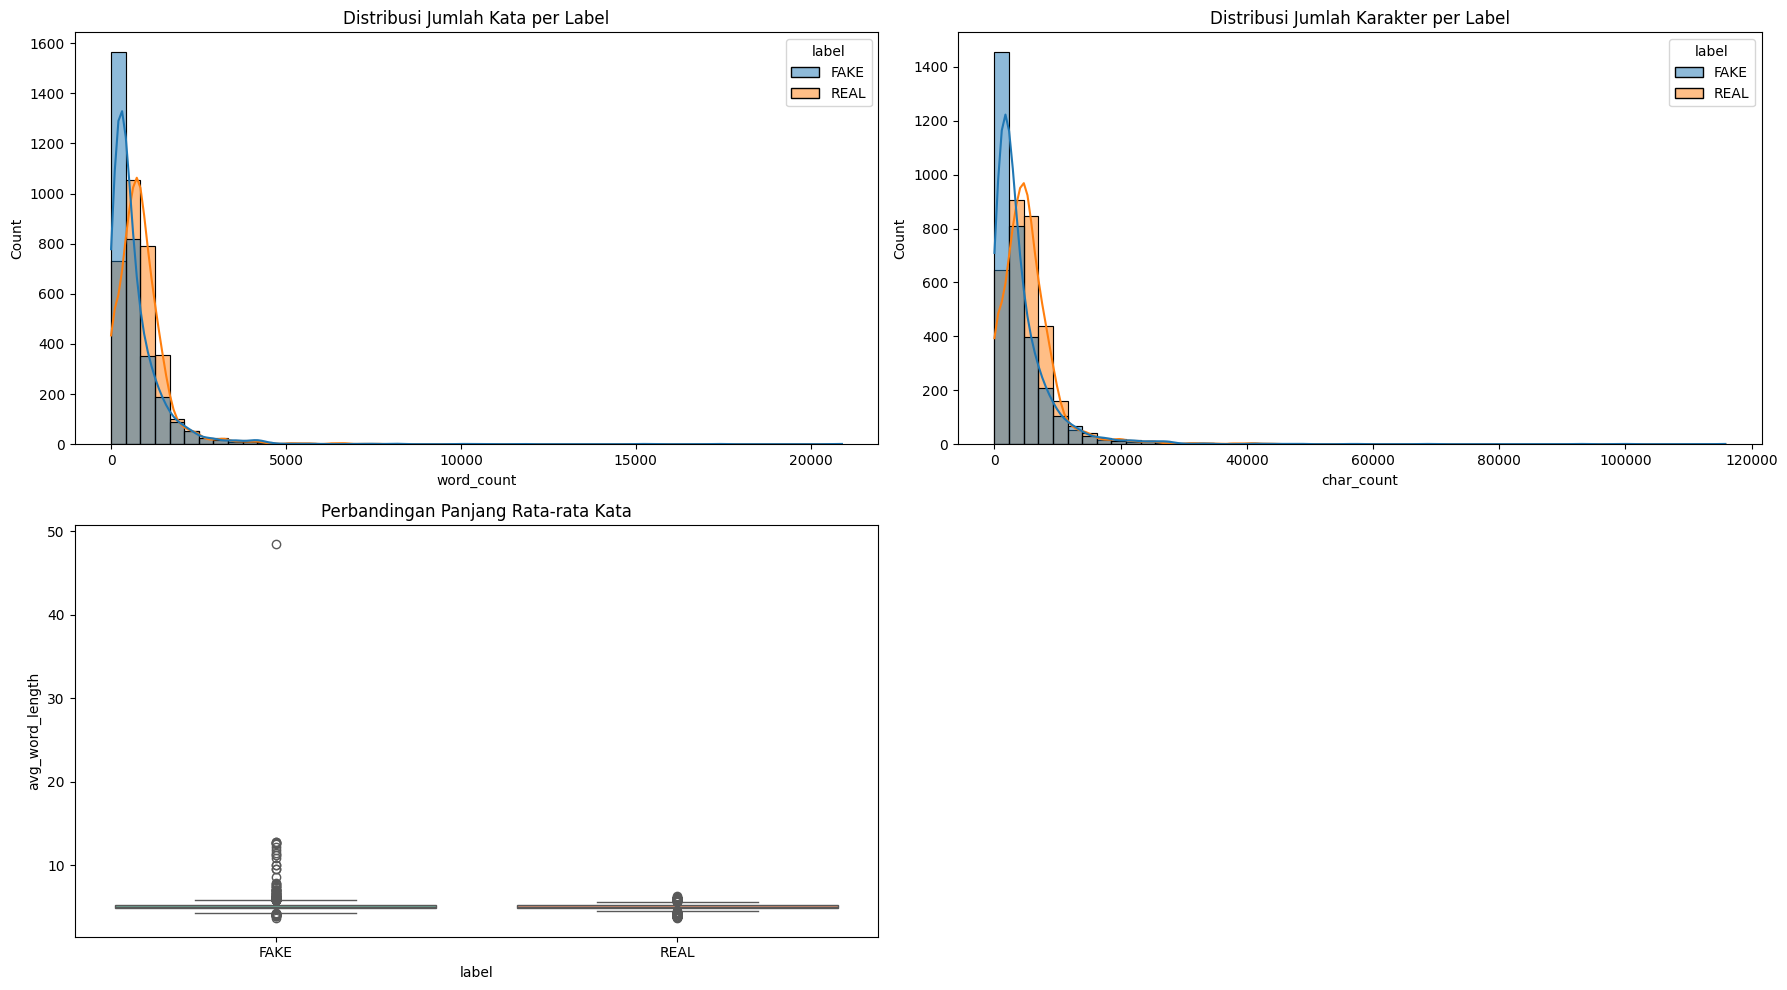

In [14]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.histplot(data=df, x='word_count', hue='label', bins=50, kde=True)
plt.title('Distribusi Jumlah Kata per Label')

plt.subplot(2,2,2)
sns.histplot(data=df, x='char_count', hue='label', bins=50, kde=True)
plt.title('Distribusi Jumlah Karakter per Label')

plt.subplot(2,2,3)
sns.boxplot(data=df, x='label', y='avg_word_length', palette='Set2')
plt.title('Perbandingan Panjang Rata-rata Kata')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing
Teks mentah biasanya mengandung simbol, angka, dan kata tidak penting (*stopwords*). Tahap ini bertujuan menyiapkan teks agar siap digunakan dalam *feature extraction*.

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [w for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hibino\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,text,clean_text
0,"Daniel Greenfield, a Shillman Journalism Fello...",daniel greenfield shillman journalism fellow f...
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,google pinterest digg linkedin reddit stumbleu...
2,U.S. Secretary of State John F. Kerry said Mon...,us secretary state john f kerry said monday st...
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",— kaydee king kaydeeking november lesson tonig...
4,It's primary day in New York and front-runners...,primary day new york frontrunners hillary clin...


## 4. Feature Extraction (Textual Features)
Berdasarkan materi *Feature Extraction and Selection*, teks memiliki berbagai jenis fitur yang dapat diekstrak. Pada notebook ini digunakan dua metode utama:

1. **Bag of Words (BoW)** – menghitung frekuensi kemunculan kata.
2. **TF-IDF (Term Frequency – Inverse Document Frequency)** – memberi bobot pada kata berdasarkan seberapa unik kata tersebut di seluruh dokumen.

Kedua metode menghasilkan representasi vektor yang bisa digunakan untuk klasifikasi.

### 4.1 Bag of Words (BoW)
BoW mengubah teks menjadi vektor berdasarkan frekuensi kata tanpa memperhatikan urutan kata. Cocok untuk model sederhana seperti *Naive Bayes* atau *Logistic Regression*.

In [16]:
bow_vectorizer = CountVectorizer(max_features=3000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label']

print('Bentuk matriks BoW:', X_bow.shape)
print('Contoh 10 fitur pertama:', bow_vectorizer.get_feature_names_out()[:10])

Bentuk matriks BoW: (6335, 3000)
Contoh 10 fitur pertama: ['abc' 'abedin' 'ability' 'able' 'abortion' 'abroad' 'absolutely' 'abuse'
 'accept' 'accepted']


### 4.2 TF-IDF (Term Frequency – Inverse Document Frequency)
Metode ini memberi bobot lebih tinggi pada kata yang jarang muncul di seluruh dokumen tetapi sering muncul pada satu dokumen, sehingga lebih informatif daripada BoW.

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text']).toarray()
print('Bentuk matriks TF-IDF:', X_tfidf.shape)
print('Contoh 10 fitur pertama:', tfidf_vectorizer.get_feature_names_out()[:10])

Bentuk matriks TF-IDF: (6335, 3000)
Contoh 10 fitur pertama: ['abc' 'abedin' 'ability' 'able' 'abortion' 'abroad' 'absolutely' 'abuse'
 'accept' 'accepted']


## 5. Train-Test Split dan Label Encoding
Data akan dibagi menjadi data latih dan data uji untuk evaluasi model yang akan datang.

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print('Data siap digunakan untuk modeling:')
print('BoW Train Shape:', X_train_bow.shape)
print('TF-IDF Train Shape:', X_train_tfidf.shape)

Data siap digunakan untuk modeling:
BoW Train Shape: (5068, 3000)
TF-IDF Train Shape: (5068, 3000)


## 6. Kesimpulan
Tahap EDA dan Preprocessing ini memberikan pemahaman mendalam terhadap dataset dan menyiapkan dua bentuk representasi fitur utama:

1. **BoW**: Representasi sederhana berbasis frekuensi kata.
2. **TF-IDF**: Representasi berbobot yang menyoroti kata unik.

Kedua hasil tersebut siap digunakan untuk tahap berikutnya, yaitu **Modeling dan Evaluasi** dengan algoritma klasifikasi teks.